# <a href="https://thetahat.ru/courses/ad">Введение в анализ данных</a>

## Линейная регрессия

В данном ноутбуке мы рассмотрим несложный пример построения модели линейной регрессии, а также предварительной обработки данных. Для построения моделей и методов обработки данных будем использовать широко известную библиотеку <a target="_blank" href="https://scikit-learn.org/">Scikit-Learn</a> (сокращенно `sklearn`), в которой в удобной форме реализованы многие методы машинного обучения и анализа данных в целом. Более того, принятый интерфейс библиотеки часто используют разработчики других библиотек в силу удобства его использования.

Поставить библиотеку можно командой `pip install scikit-learn`.

In [1]:
from typing import Tuple, Optional, Any, Dict, List
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics

sns.set(font_scale=1.3, palette="Set2")
RANDOM_STATE = 42  # фиксируем зерно случайности
CURR_DATE = str(datetime.now().date())  # сегодняшняя дата
DAYS_PER_YEAR = 365  # количество дней в году
pd.options.mode.chained_assignment = None

### 1. Линейная регрессия на искусственных данных

#### 1.1 Данные

Рассмотрим задачу обучения модели на искусственных данных, которые генерируются с помощью нелинейной функции с аддитивным шумом. Данные описываются зависимостью  $y = f(x) + \varepsilon$.

* $ f(x) = 3x + 4\sin{x} $ — истинная целевая функция.
* $\varepsilon$ — аддитивный шум, следующий нормальному распределению $\varepsilon \sim \mathcal{N}(0, 1)$.


В контексте этой задачи, ключевой момент будет заключаться в изучении, насколько линейная регрессия может приблизить этот вид нелинейной зависимости.

In [2]:
def generate_linear_data(
    n_samples: int = 100, theta1: float = 3.0, theta2: float = 4.0, X_max: float = 10.0
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Генерирует данные для линейной модели
    y = features * theta1 + sin(features) * theta2 + ε, где ε ~ N(0, 2).

    Параметры:
    n_samples (int): Количество выборок (по умолчанию 100).
    theta1 (float): Коэффициент для линейной зависимости (по умолчанию 3.0).
    theta2 (float): Коэффициент для зависимости от синуса features (по умолчанию 4.0).
    X_max (float): Максимальное значение для генерации features (по умолчанию 10.0).

    Возвращает:
    Tuple[np.ndarray, np.ndarray]: Кортеж из двух массивов numpy: features и target_values.
    """
    # Признаки: енерация случайных значений от 0 до X_max
    features = np.random.uniform(low=0.0, high=1.0, size=(n_samples, 1)) * X_max
    # Генерация шума
    noise = np.random.normal(loc=0.0, scale=2.0, size=(n_samples, 1))

    # Вычисление target согласно функции
    target_values = features * theta1 + np.sin(features) * theta2 + noise

    return features, target_values

In [3]:
n_samples = 60  # количество элементов в выборке
theta1 = 3  # коэффициент для линейной зависимости
theta2 = 4  # коэффициент при sin(x)
X_max = 3  # максимальное значение X

X_grid = np.linspace(0, X_max, n_samples)  # равномерная сетка для X от 0 до X_max
X, y = generate_linear_data(n_samples=n_samples, theta1=theta1, theta2=theta2, X_max=X_max)

Визуализируем данные и истинную зависимость $$f(x) = 3x + 4\sin{x}$$

In [4]:
def plot_regression_results(
    X: np.ndarray,
    y: np.ndarray,
    theta1: float,
    theta2: float,
    X_grid: np.ndarray,
    models: Optional[Dict[str, Optional[Any]]] = None,
    features_grid_list: Optional[List[np.ndarray]] = None,
    title: str = "Сравнение предсказаний моделей",
) -> None:
    """
    Отображает результаты линейной регрессии вместе 
    с истинной зависимостью и данными.

    Параметры:
    X (np.ndarray): Входные данные.
    y (np.ndarray): Целевые значения.
    theta1 (float): Коэффициент для линейной зависимости.
    theta2 (float): Коэффициент для зависимости от синуса.
    X_grid (np.ndarray): Сетка для отображения исходной зависимости.
    models (Optional[Dict[str, Optional[Any]]]): Словарь, где ключи — подписи, а
        значения — модели, реализующие метод predict (могут быть None).
    features_grid_list (Optional[List[np.ndarray]]): Список массивов сетки признаков
        для каждой модели.
    title (str): Заголовок графика (по умолчанию "Сравнение предсказаний моделей").
    """
    plt.figure(figsize=(9, 5))

    # Отображение данных
    sns.scatterplot(
        x=X.reshape(-1), y=y.reshape(-1), label="Данные", alpha=0.5, s=80, color="purple"
    )

    # Истинная зависимость
    sns.lineplot(
        x=X_grid,
        y=X_grid * theta1 + np.sin(X_grid) * theta2,
        label="Истинная зависимость",
        linewidth=3,
        linestyle="--",
    )

    # Проверяем, переданы ли модели и соответствующие данные
    if models and features_grid_list:
        for (label, model), features_grid in zip(models.items(), features_grid_list):
            sns.lineplot(
                x=X_grid,
                y=model.predict(features_grid).reshape(-1),
                label=f"Предсказ.: {label}",
                linewidth=3,
            )

    plt.title(title)
    plt.xlabel("Признак $x$")
    plt.ylabel("Таргет")
    plt.ylim(-2, 17)
    plt.legend()
    plt.show()

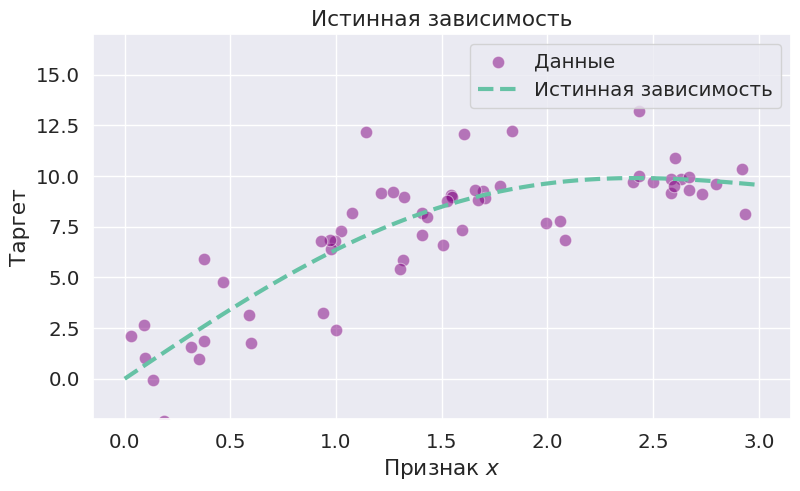

In [5]:
plot_regression_results(X, y, theta1, theta2, X_grid, title="Истинная зависимость")

#### 1.2 Модель

Попробуем предсказать значение $y$ по значению $x$, обучив для начала модель линейной регрессии по признаку $X_1 = x$.
Множество модель линейной регрессии в данном случае имеет вид:
$$
\widehat{y}(x) = \theta_0 + \theta_1 x,
$$
где:
- $ \theta_0 \in \mathbb{R} $ — свободный член (intercept),
- $ \theta_1 \in \mathbb{R} $ — коэффициент при признаке $ x $.

Модель предполагает, что зависимость между $ x $ и $ y $ линейна. В нашей задаче истинная зависимость нелинейная, поэтому модель линейной регрессии может не дать хорошего приближения.


---
Будем использовать <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">`LinearRegression`</a>.

>**Важные аргументы конструктора:**
>* `fit_intercept` &mdash; нужно ли включать в модель свободный член. В случае `fit_intercept=True` модели не нужно передавать признак из всех единиц для того, чтобы она оценивала свободный член. По умолчанию `fit_intercept=True`.
>
>**Основные методы класса:**
>* `fit(X, y)` &mdash; обучить линейную регрессию на основе данных `X` предсказывать целевой признак `y`. В данном случае под термином "обучить" поднимается вычисление оценки коэффициентов $\widehat{\theta}$.
>
>* `predict(X)` &mdash; предсказать по данным `X` целевой признак `y`. В данном случае под термином "предсказать" поднимается вычисление оценки целевого признака $\widehat{y}$.
>
>Используем `fit_intercept=True` для оценки свободного коэффициента, что позволяет не добавлять в матрицу признаков столбец из единиц.

---
Вспомним, как работают методы `fit`, `predict`:

&#x2753; **Вопрос** &#x2753;

> Как получается оценки параметра $\theta$ в методе `fit`?

<details>
  <summary> Кликни для показа ответа </summary>


> Делает оценку параметра $\theta \in \mathbb{R}^d$, минимизируя среднеквадратичную ошибку между предсказанными значениями  и истинными значениями $Y \in \mathbb{R}^n$ на обучающем множестве данных с матрицей признаков $X \in \mathbb{R}^{n \times d}$:
> 
>   $$\widehat{\theta} = (X^TX)^{-1}X^TY$$

</details><br/>



&#x2753; **Вопрос** &#x2753;

> Как получается оценки целевого признака в методе `predict`?

<details>
  <summary> Кликни для показа ответа </summary>

> Для матрицы признаков $X_{new} \in \mathbb{R}^{k \times d}$ получает оценку целевого признака по формуле:
> 
>  $$ \widehat{Y}_{new} = X_{new}\widehat{\theta}$$

</details><br/>

Обучаем модель линейной регрессии на данных, используя только один признак $ x $.


In [6]:
model = LinearRegression()  # объявляем модель
model.fit(X, y)  # обучаем на признаке x

LinearRegression()

Оценки свободного коэффициента $\theta_0$ и коэффициента $\theta_1$ при $x$

In [7]:
model.intercept_, model.coef_

(array([2.12918503]), array([[3.33851323]]))

Сравним предсказания модели с истинной зависимостью.


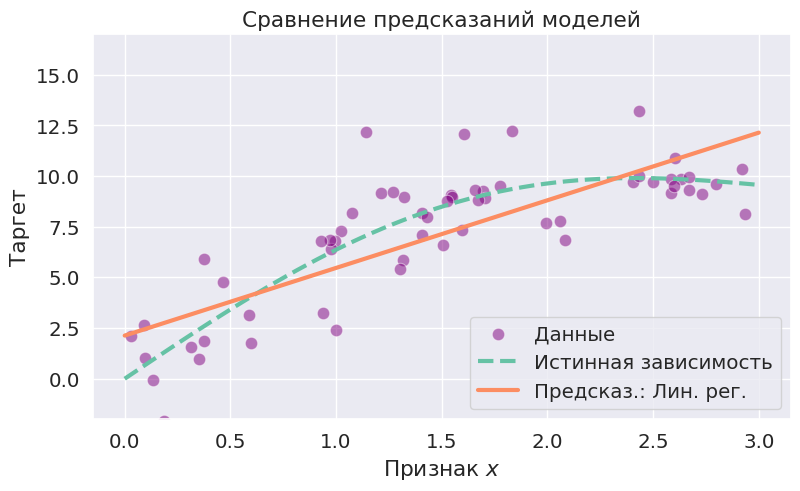

In [8]:
models = {"Лин. рег.": model}  # Словарь моделей
features_grids = [X_grid.reshape(-1, 1)]  # Сетка признаков для модели

plot_regression_results(X, y, theta1, theta2, X_grid, models, features_grids)

&#x2753; **Вопрос** &#x2753;

> Что можно сделать для повышения точности предсказаний?

<details>
  <summary> Кликни для показа ответа </summary>
  
> 1. **Усложнить модель**.
> Если текущая модель (например, линейная регрессия) недостаточно хорошо учитывает сложные зависимости в данных, можно перейти на более сложные модели, которые способны учитывать нелинейные зависимости и взаимосвязи между признаками.
> 
> 
> 
> 2. **Добавить новые признаки.**
> 
>     Примеры преобразований:
>       * Из временн*ы*х данных можно извлечь день недели, месяц, год или временн*ы*е интервалы.
> 
>       * Полиномиальные признаки. Добавление квадратов, кубов или произведений существующих признаков может помочь модели уловить нелинейные зависимости.
> 
>       * Создание новых признаков как комбинаций существующих (например, умножение или деление двух признаков).
> 
>       * Группировка числовых признаков в интервалы (например, возрастные группы).
> 
>       * Кодирование категориальных признаков. Использование One-Hot Encoding для преобразования категориальных данных в числовые.
> 
> Далее рассмотрим второй вариант.
</details><br/>

---
#### 1.3 Модель с нелинейными признаками

Видим, что исходная зависимость не является линейной, а предсказания модели линейны по $x$, поэтому такая модель может быть не очень хорошей для наших данных. Попробуем добавить нелинейные признаки и сделать предсказания с их использованием.

Одно нелинейных преобразований &mdash; полиномиальное преобразование (в данном случае попробуем использовать признак $x^2$). Добавим $x^2$ в матрицу признаков.

In [9]:
model_2 = LinearRegression()  # объявляем модель

data = pd.DataFrame(
    {"X": X.flatten(), "X^2": X.flatten() ** 2}
)  # создаем новый датасет с использованием X^2

data.head()

,X,X^2
0,1.775631,3.152866
1,1.316865,1.734133
2,1.021932,1.044345
3,0.464603,0.215856
4,0.103619,0.010737


&#x2753; **Вопрос** &#x2753;

> Какой вид будет иметь модель линейной регрессии при добавлении нового признака?

<details>
  <summary> Кликни для показа ответа </summary>
  
> $$
\widehat{y}(x) = \theta_0 + \theta_1 x + \theta_2 x^2,
$$
> - $ \theta_0 \in \mathbb{R} $ — свободный член (intercept),
> - $ \theta_1$, $\theta_2 \in \mathbb{R} $ — коэффициенты при $ x $ и $x^2$.
</details><br/>



In [10]:
model_2.fit(data, y)  # обучим модель на новых данных

LinearRegression()

Посмотрим, какие предсказания выдает модель, обученная на полиномиальных признаках.

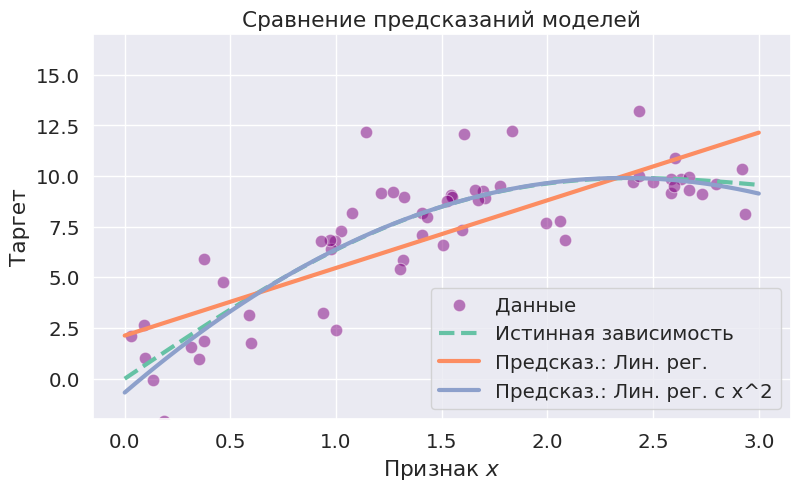

In [11]:
models["Лин. рег. с x^2"] = model_2

features_grids.append(
    pd.DataFrame({"X": X_grid.flatten(), "X^2": X_grid.flatten() ** 2})
)

plot_regression_results(X, y, theta1, theta2, X_grid, models, features_grids)

По графику видно, что модель, обученная с добавлением признака, лучше приближает исходную зависимость.

**Результаты**
1. Линейная регрессия с одним признаком $ x $ не способна хорошо аппроксимировать нелинейную зависимость.
2. Добавление полиномиального признака $ x^2 $ улучшает качество модели, но всё равно не позволяет точно описать истинную зависимость $ f(x) = 3x + 4\sin{x} $.
3. Для более точного описания данных можно рассмотреть другие нелинейные признаки (например, $ \sin{x} $) или использовать более сложные модели.

### 2. Постановка задачи на реальных данных

Рассмотрим <a href="https://thetahat.ru/files/ad/main/3/insurance_thetahat.csv" download="insurance_thetahat.csv" >данные</a> медицинского страхования. В каждой строке представлены признаки для каждого клиента страховой организации.

В данных содержатся следующие признаки:
* `birthday` &mdash; день рождения *(в версии ThetaHat; в оригинальной версии `age` — возраст*);;
* `sex` &mdash; пол, возможные значения: `female`, `male`;
* `bmi`  &mdash; соотношение массы тела квадрату его высоты (body mass index), измеряется в кг/м$^2$, хорошие значения лежат в диапазоне от 18.5 до 24.9;
* `children` &mdash; количество детей;
* `smoker` &mdash; курит ли клиент;
* `region` &mdash; район в США, возможные значения: `northeast`, `southeast`, `southwest`, `northwest`;
* `charges` &mdash; индивидуальные медицинские расходы, оплачиваемые медицинским страхованием.

**Задача:** предсказать *индивидуальные медицинские расходы* по остальным признакам.\
\
Это может быть полезно для таких целей:
  
- **Определение оптимальных взносов:** На основании предсказанных медицинских расходов компании могут устанавливать размер страховых взносов таким образом, чтобы они покрывали ожидаемые траты.
- **Оптимизация страховок:** Определять, какие группы населения более подвержены высоким расходам, и разрабатывать продукты и тарифы, которые лучше обслуживают эти сегменты рынка.
- **Осведомленность и планирование:** Пациенты могут использовать информацию, чтобы понять, как их образ жизни и личные характеристики могут влиять на будущие медицинские расходы, и предпринять шаги по их снижению, например, прекращение курения или поддержание здорового веса.




Оригинальные данные можно посмотреть на <a target="_blank" href="https://www.kaggle.com/mirichoi0218/insurance">Kaggle</a>.

Загрузим данные

In [12]:
data = pd.read_csv("./insurance_thetahat.csv", parse_dates=[0])
data.head()

,birthday,sex,bmi,children,smoker,region,charges
0,2001-12-20,female,27.900,0,yes,southwest,16884.92400
1,2003-03-18,male,33.770,1,no,southeast,1725.55230
2,1992-11-02,male,33.000,3,no,southeast,4449.46200
3,1987-07-27,male,22.705,0,no,northwest,21984.47061
4,1988-11-04,male,28.880,0,no,northwest,3866.85520


Посмотрим на размер таблицы

In [13]:
data.shape

(1338, 7)

Тестировать качество построенной модели всегда нужно на данных, которые не участвовали в обучении. Такие данные называются *тестовыми*. Данные, которые участвуют в обучении, называются *обучающими*.

Выполнить **разбиение на обучающие и тестовые данные** можно с помощью функции <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html">`train_test_split`</a>.
Применим эту функцию к нашим данным, отнеся в тестовую часть 20% данных, а в обучающую &mdash; остальные 80%.

In [14]:
train, test = train_test_split(data, test_size=0.2, random_state=RANDOM_STATE)
train.shape, test.shape

((1070, 7), (268, 7))

### 3. Обучение

Сразу приведем временн*о*й признак, а именно, построим из него признак, отвечающий за возраст человека. Дробные значения отбрасывать смысла нет. При выполнении преобразования учитываем, <a href="https://thetahat.ru/courses/python/06">как в `pandas` можно работать с интервалами времени</a> (см. разделы 4-5).

*Примечание.* Данную операцию можно было выполнить сразу для всех данных. Но лучше так не делать, поскольку в других примерах таким способом иногда можно "подглядеть" в тестовые данные.

In [15]:
train["age"] = (pd.Timestamp(CURR_DATE) - train["birthday"]) / pd.Timedelta(days=DAYS_PER_YEAR)

Выделим группы признаков

In [16]:
categorial_features = ["sex", "smoker", "region"]  # категориальные признаки
real_features = ["age", "bmi", "children"]  # вещественные признаки
target_feature = "charges"  # целевой признак

Посмотрим на визуализацию совместных распределений вещественных признаков при помощи `PairGrid`, причем будем разбивать данные по одному признаку из числа категориальных. На графиках приведены:
* данные в виде точек для каждой пары вещественных признаков;
* ядерные оценки плотности для каждой пары вещественных признаков;
* ядерные оценки плотности для всех вещественных признаков по отдельности.

Подробнее можно почитать <a href="https://thetahat.ru/courses/python/07">в обучающих материалах</a> в разделах 3 и 6.

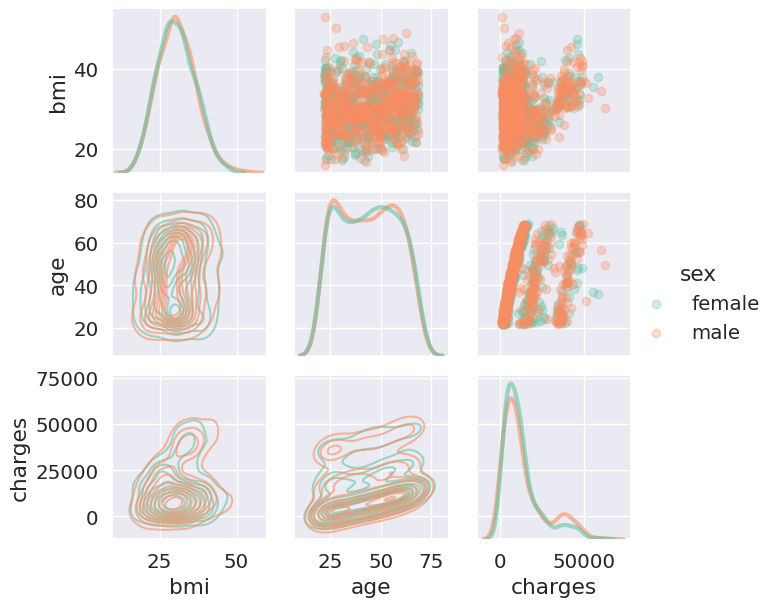

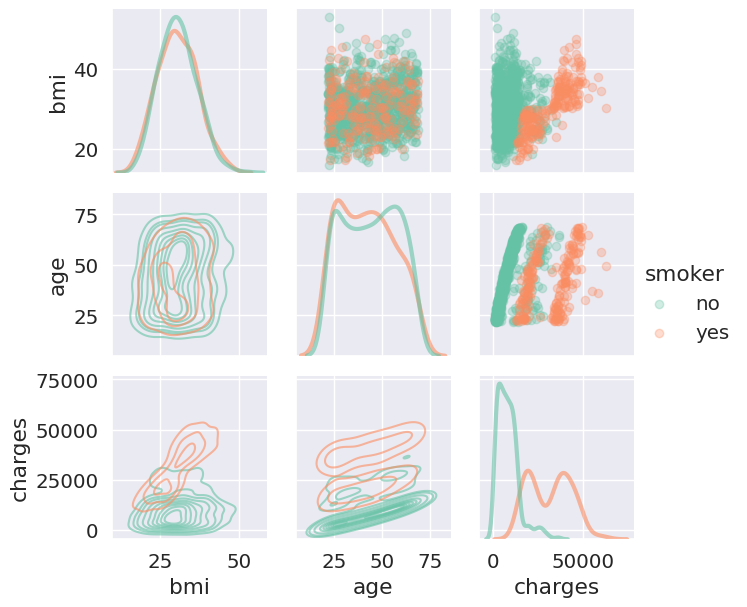

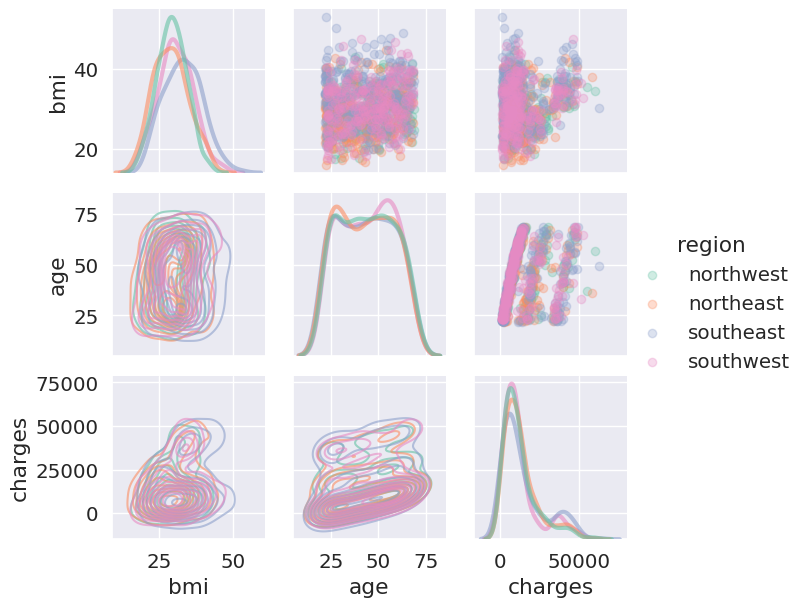

In [17]:
for hue in categorial_features:
    pair_grid = sns.PairGrid(train[["bmi", "age", "charges", hue]], hue=hue, diag_sharey=False, height=3)

    pair_grid.fig.set_size_inches(6, 6)
    pair_grid.map_lower(sns.kdeplot, alpha=0.6)
    pair_grid.map_upper(plt.scatter, alpha=0.3)
    pair_grid.map_diag(
        sns.kdeplot, lw=3, alpha=0.6, common_norm=False
    )  # каждая плотность по отдельности должна давать 1 при интегрировании

    pair_grid.add_legend()

По графикам сразу можно сделать следующие выводы:
* расходы растут с увеличением возраста клиента;
* величина расходов больше для курящих людей.

Видимо, эти признаки должны оказать существенное влияние при построении регрессионной модели.

---
Напомним, как работают методы `fit` и `predict`:



>`fit`
>
>Делает оценку параметра $\theta$, минимизируя среднеквадратичную ошибку между предсказанными значениями $ \hat{y} $  и истинными значениями $y$:
>
>  $$
  \widehat{\theta} = (X^TX)^{-1}X^Ty
  $$
>
>`predict`
>
>Получает оценку целевого признака по формуле:
>
>$$ \widehat{Y}_{new} = X_{new}\widehat{\theta}$$

---
Теперь попробуем обучить модель линейной регрессии, используя различные наборы признаков

#### 3.1 Примеры с использованием одного или двух признаков

**Признак `age`**

In [18]:
model_age = LinearRegression()  # объявляем модель
model_age.fit(train[["age"]], train[target_feature])  # обучаем на признаке age

LinearRegression()

Выполним преобразование для получения возраста на тестовых данных. Напомним еще раз, что некоторые преобразования можно было сделать со всеми данными, это было бы корректно. Однако во избежание ошибок в будущем рекомендуем определять преобразования только по обучающим данным, а затем применять их для тестовых.

In [19]:
# Получаем возраст клиента по дате рождения
test["age"] = (pd.Timestamp(CURR_DATE) - test["birthday"]) / pd.Timedelta(days=DAYS_PER_YEAR)

Получим предсказание модели для тестовых и обучающих данных

In [20]:
y_pred = model_age.predict(test[["age"]])

Выведем коэффициент, полученный при обучении модели регрессии

In [21]:
print(model_age.coef_[0].round(2))

240.47


&#x2753; **Вопрос** &#x2753;

> Как можно интерпретировать значение коэффициентов в модели линейной регрессии?

<details>
  <summary> Кликни для показа ответа </summary>
  
> Коэффициент в линейной регрессии равен изменению таргета при изменении признака на 1. Численно это значит, что в данной модели при увеличении возраста человека на 1 год **предсказание затрат увеличивается на ~ 240.**

</details><br/>

In [22]:
preds = model_age.predict(pd.DataFrame({"age": [33, 34]}))

print("Предсказание расходов")
print(f"33 года: {preds[0]:.0f}")
print(f"34 года: {preds[1]:.0f}")

Предсказание расходов
33 года: 10758
34 года: 10999


**Признак `bmi`**

In [23]:
model_bmi = LinearRegression()
model_bmi.fit(train[["bmi"]], train[target_feature])
y_pred = model_bmi.predict(test[["bmi"]])

print(model_bmi.coef_[0].round(2))

392.44


По предсказанию модели при увеличении индекса массы тела на 1 расходы увеличиваются на ~392

**Признаки `bmi` и `age`**

Обучим теперь модель с двумя признаками и посмотрим на интерпретацию коэффициентов

In [24]:
model_bmi_age = LinearRegression()
model_bmi_age.fit(train[["bmi", "age"]], train[target_feature])
y_pred = model_bmi_age.predict(test[["bmi", "age"]])

Выведем коэффициенты

In [25]:
print(model_bmi_age.coef_)

[330.40058921 223.55689301]


Численные значения изменений в зависимости от увеличения bmi/age на 1 будут в точности равны соответствующим коэффициентам в данной модели.

Рассмотрим предсказания медицинских затрат для объекта:

* `age` = 20, `bmi` = 18

И со сдвигом на единицу по одному или обоим признакам:
* `age` = 21, `bmi` = 19
* `age` = 20, `bmi` = 19
* `age` = 21, `bmi` = 18

In [26]:
# Основные точки
bmi_values = np.array([18, 19])
age_values = np.array([20, 21])

# Данные для предсказаний
objects = pd.DataFrame({"bmi": np.tile(bmi_values, 2), "age": np.repeat(age_values, 2)})
preds = model_bmi_age.predict(objects)
objects["charges_predicted"] = preds

objects

,bmi,age,charges_predicted
0,18,20,3884.113089
1,19,20,4214.513678
2,18,21,4107.669982
3,19,21,4438.070571


Посмотрим на визуализацию

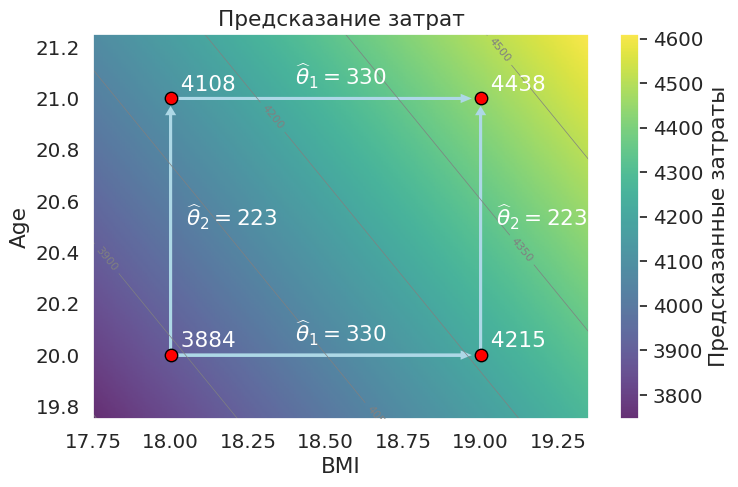

In [27]:
# Генерация значений с отступами
bmi_range = np.linspace(bmi_values.min() - 0.25, bmi_values.max() + 0.35, 200)
age_range = np.linspace(age_values.min() - 0.25, age_values.max() + 0.25, 200)

# 2D-сетка
bmi_grid, age_grid = np.meshgrid(bmi_range, age_range)

# Предсказания на сетке
pred_grid = model_bmi_age.predict(
    pd.DataFrame({"bmi": bmi_grid.ravel(), "age": age_grid.ravel()})
).reshape(bmi_grid.shape)

# Визуализация
plt.figure(figsize=(8, 5))
plt.grid(False)

# Градиент
im = plt.imshow(
    pred_grid,
    extent=(bmi_range.min(), bmi_range.max(), age_range.min(), age_range.max()),
    origin="lower",
    cmap="viridis",
    alpha=0.8,
    aspect="auto",
)

# Линии контуров
contour = plt.contour(bmi_grid, age_grid, pred_grid, colors="grey", linewidths=0.5)

# Отображение признаков
plt.scatter(objects["bmi"], objects["age"], color="red", edgecolor="black", zorder=5, s=80)
for i, row in objects.iterrows():
    plt.text(
        row["bmi"] + 0.01,
        row["age"] + 0.03,
        f" {row['charges_predicted']:.0f} ",
        ha="left",
        color="white",
        zorder=6,
    )

# Добавление стрелок с подписями
for bmi in bmi_values:
    for age in age_values:
        if bmi == bmi_values.min():
            plt.arrow(
                bmi,
                age,
                1 - 0.06,
                0,
                head_width=0.02,
                head_length=0.02,
                fc="lightblue",
                ec="lightblue",
                linewidth=2,
            )
            plt.text(
                bmi + 0.4,
                age + 0.05,
                rf"$\widehat{{\theta}}_1 = {int(model_bmi_age.coef_[0])}$",
                color="white",
            )
        if age == age_values.min():
            plt.arrow(
                bmi,
                age,
                0,
                1 - 0.06,
                head_width=0.02,
                head_length=0.02,
                fc="lightblue",
                ec="lightblue",
                linewidth=2,
            )
            plt.text(
                bmi + 0.05,
                age + 0.5,
                rf"$\widehat{{\theta}}_2 = {int(model_bmi_age.coef_[1])}$",
                color="white",
            )

# Подписи осей
plt.title("Предсказание затрат")
plt.xlabel("BMI")
plt.ylabel("Age")

# Цветовая шкала
cbar = plt.colorbar(im, label="Предсказанные затраты")

# Добавление подписей к линиям контуров
plt.clabel(contour, inline=True, fontsize=8, fmt="%1.0f")

plt.show()

⬆️ На графике представлены точки, каждая из которых соответствует человеку в возрасте 20 или 21 года с индексом массы тела (BMI) 18 или 19. Стрелки на графике указывают направление изменения положения точки при увеличении возраста или BMI на единицу, и как это влияет на предполагаемые медицинские затраты.

По графику видно, что при изменении индекса массы тела на 1 предсказания затрат меняются на 330 у.е., что соответствует оценке коэффициента перед признаком `bmi`. Важно отметить, что возраст при этом не изменился. Аналогично, при изменении возраста на 1 и неизменном индексе массы тела предсказания затрат меняются на 223 у.е., что соответствует оценке коэффициента перед признаком `age`. 


Таким образом, мы можем сделать важный вывод **об интерпретации коэффициентов линейной регрессии**. Коэффициент $\widehat{\theta}_j$ перед признаком $x_j$ показывает величину изменения целевого признака при изменении $x_j$ на 1 и *фиксированных значениях остальных признаков*. Более того, коэффициент $\widehat{\theta}_j$ имеет размерность, равную отношению размерностей целевого признака и признака $x_j$.

---
#### 3.2 Обработка категориальных признаков

Далее **закодируем категориальные признаки** с помощью класса <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html">`OneHotEncoder`</a>. Напомним, данный метод из одного категориального признака делает несколько бинарных признаков по количеству различных значений исходного категориального признака. Например, если исходный признак принимал 5 различных значений, то его кодировкой будет 5 новых бинарных признаков, где единица будет только у того бинарного признака, который соответствует данному значению исходного категориального признака. Иногда, *например, для линейной регрессии*, необходимо делать на один бинарный признак *меньше*, поскольку значения оставшегося бинарного признака можно выразить из значений всех остальных бинарных признаков.

>**Важные аргументы конструктора:**
>* `categories` &mdash; если установлено значение `auto`, то категории определяются по имеющемуся объему данных, иначе, используется список категорий, который передается этим аргументом.
* `drop` &mdash; указывает методику, используемую для удаления одной из категорий для каждого объекта. Это может быть полезно для некоторых моделей, например, для линейной регрессии. Возможные значения указаны далее.
  * `None` &mdash; оставляем все признаки.
  * `'first'` &mdash; удаляет первую категорию для каждого признака. Если признак имеет одну категорию, то он будет удален полностью.
  * `'if_binary'` &mdash; удаляет первую категорию только для бинарных признаков.
  * массив`drop`, где `drop[i]` &mdash; категория в признаке feature `X[:, i]`, которая должна быть удалена.
* `sparse_output` &mdash; возвращает sparse-матрицу, если установлено значение `True`, иначе &mdash; массив.
>
>**Основные методы класса:**
* `fit(X)` &mdash; обучить кодировщик кодировать признаки на основе данных `X`. В данном случае под термином "обучить" поднимается определение функций кодирования и декодирования признаков.
* `transform(X)` &mdash; закодировать признаки в данных `X`.
* `fit_transform(X)` &mdash; обучить кодировщик по данным `X` и сразу их закодировать.
* `inverse_transform(X)` &mdash; декодировать признаки в данных `X`, то есть перевести бинарные признаки в исходные категориальные.

---

При построении кодировщика для наших данных учтем ряд особенностей:
* указываем `drop='first'`, то есть одну категорию нужно исключить;
* указываем `sparse_output=False`, то есть вернуть нужно неразреженную матрицу;
* нужно выполнить *обучение*, что в данном случае подразумевает построение и сохранение правила преобразования;
* сразу же кодируем признаки из обучающего множества;

In [28]:
encoder = OneHotEncoder(drop="first", sparse_output=False)  # объявляем модель

# Внимание! Нельзя вызывать fit_transform на тестовых данных!
train_cat = encoder.fit_transform(train[categorial_features])  # обучаем и кодируем
train_cat

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1.]], shape=(1070, 5))

Можем посмотреть на то, как у нас "обучились" категории. Для каждого категориального признака приведен список его категорий

In [29]:
encoder.categories_

[array(['female', 'male'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]

#### 3.3 Обучение на всех признаках

Соединим вместе вещественные признаки и закодированные категориальные

In [30]:
X_train = np.hstack([train[real_features], train_cat])
X_train.shape

(1070, 8)

Обучим модель, используя категориальные и вещественные признаки

In [31]:
model_full = LinearRegression()
model_full.fit(X_train, train[target_feature])

LinearRegression()

Посмотрим на результат обучения. Оценки коэффициентов перед признаками

In [32]:
model_full.coef_

array([  257.14354577,   336.56325568,   423.94099187,   -25.48434935,
       23656.64811639,  -370.88646373,  -659.67773002,  -818.2905385 ])

Оценка свободного коэффициента

In [33]:
model_full.intercept_

np.float64(-13047.695966930763)

### 4. Тестирование и оценка качества

Пусть мы обучили конкретную модель и можем получать предсказания таргета. Для оценки качества полученных предсказаний можно использовать различные функционалы ошибки и функционалы качества. Далее рассмотрим некоторые из них

In [34]:
# Получаем возраст клиента по дате рождения
test["age"] = (pd.Timestamp(CURR_DATE) - test["birthday"]) / pd.Timedelta(days=DAYS_PER_YEAR)

# Кодируем категориальные признаки с помощью метода transform обученного ранее кодировщика
test_cat = encoder.transform(test[categorial_features])

# Соединяем данные
X_test = np.hstack([test[real_features], test_cat])

Выполним *предсказания* построенными ранее моделями с помощью метода `predict`

In [35]:
# Словарь для моделей и соответствующих предсказаний
model_dict = {
    "age": {"model": model_age},
    "bmi": {"model": model_bmi},
    "age+bmi": {"model": model_bmi_age},
    "все признаки": {"model": model_full},
}

# Обучающие данные для каждой модели, отличаются только набором признаков
train_data = {
    "age": train[["age"]],
    "bmi": train[["bmi"]],
    "age+bmi": train[["bmi", "age"]],
    "все признаки": X_train,
}

# Тестовые данные для каждой модели, отличаются только набором признаков
test_data = {
    "age": test[["age"]],
    "bmi": test[["bmi"]],
    "age+bmi": test[["bmi", "age"]],
    "все признаки": X_test,
}

for name, data in model_dict.items():
    model = data["model"]
    data["train_preds"] = model.predict(train_data[name])
    data["test_preds"] = model.predict(test_data[name])

>Посчитать **ошибку предсказания** можно разными способами. Наиболее популярный способ &mdash; **метрика MSE** (*mean squared error*). Пусть $Y_1, ..., Y_n$ &mdash; истинные значения, а $\widehat{Y}_1, ..., \widehat{Y}_n$ &mdash; предсказания. Тогда метрика MSE определяется как
$$MSE = \frac{1}{n}\sum_{i=1}^n \left(Y_i - \widehat{Y}_i\right)^2.$$

*Замечание.* В анализе данных функционалы качества и функционалы ошибки предсказания принято называть метриками. Данные метрики не имеют никакого отношения к функциям расстояния, в качестве которых термин "метрика" используется в математическом анализе.

Посчитаем ее, а точнее &mdash; корень из нее, который еще обозначается как RMSE (*root MSE*)

In [36]:
test_preds = model_dict["все признаки"]["test_preds"]
np.sqrt(((test[target_feature] - test_preds) ** 2).mean())

np.float64(5793.112670753037)

Это значение уже имеет конкретный смысл  &mdash; насколько в среднем модель отклоняется от истинного значения. То есть в среднем отклонения предсказания величины страховых расходов имеют порядок 6 000 условных единиц. Напомним, что в данных страховые расходы в основной массе принимают значения до 50 000 у.е..

Готовая <a target="_blank" href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html">реализация</a> также есть в `sklearn`:

In [37]:
metrics.mean_squared_error(test[target_feature], test_preds) ** 0.5

5793.112670753037

---
>Другой вариант &mdash; метрика **MAE** (*mean absolute error*), определяемая как
$$MAE = \frac{1}{n}\sum_{i=1}^n \left|Y_i - \widehat{Y}_i\right|.$$
>
>Ее большое преимущество в том, что она не сильно подстраивается по выбросы по сравнению с MSE. Однако ее труднее оптимизировать.

In [38]:
metrics.mean_absolute_error(test[target_feature], test_preds)

4180.120715743259

---
>Еще один популярный вариант &mdash; метрика **MAPE** (*mean absolute percentage error*), определяемая как
$$MAPE = 100\% \cdot \frac{1}{n}\sum_{i=1}^n \frac{\left|Y_i - \widehat{Y}_i\right|}{Y_i}.$$
>
>В отличии от предыдущих метрик она позволяет посчитать ошибку *в процентах*, что бывает достаточно информативно в реальных задачах.

Реализуем ее

In [39]:
def mean_absolute_percentage_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Вычисляет среднюю абсолютную процентную ошибку (MAPE).

    Параметры:
    y_true (np.ndarray): Истинные значения целевой переменной.
    y_pred (np.ndarray): Прогнозируемые значения.

    Возвращает:
    float: Средняя абсолютная процентная ошибка (MAPE) в процентах.
    """
    return 100 * (np.abs(y_true - y_pred) / y_true).mean()

Посчитаем для ее для наших данных

In [40]:
mean_absolute_percentage_error(test[target_feature], test_preds)

np.float64(46.870457081881746)

---
>Еще для измерения качества модели можно использовать **коэффициент детерминации $ R^2 $**, который также часто используется для оценки качества предсказательной модели. Этот коэффициент измеряет, какую долю дисперсии зависимой переменной модель сумела объяснить.
>
>
>Коэффициент детерминации $R^2$ рассчитывается как:
>
>$$
R^2 = 1 - \frac{\sum_{i=1}^n (Y_i - \widehat{Y}_i)^2}{\sum_{i=1}^n (Y_i - \overline{Y})^2},
$$
>
>где
> - $\sum_{i=1}^n \left(Y_i - \widehat{Y}_i\right)^2$ — сумма квадратов ошибок (SSE),
> - $\overline{Y} = \frac{1}{n} \sum_{i=1}^n Y_i$ — среднее из всех истинных значений,
> - $\sum_{i=1}^n \left(Y_i - \overline{Y}\right)^2$ — полная сумма квадратов (SST).

&#x2753; **Вопрос** &#x2753;

> Чему равно значение метрики $R^2$ для "идеальной модели"?

<details>
  <summary> Кликни для показа ответа </summary>
  
> $R^2 = 1$
> 
> 
> Интерпретация $R^2$
> 
> - $R^2 = 1$: Такая модель объясняет всю дисперсию данных (идеальный случай).
> - $R^2 = 0$: Модель не объясняет дисперсию данных лучше, чем просто среднее значение $Y$.
> - $R^2 < 0$: Модель объясняет дисперсию хуже, чем простая модель без регрессии (может случиться, если модель переобучается или плохо подходит для использования на конкретных данных).

</details><br/>





Для сравнения посчитаем предсказания и ошибки на обучающем и тестовом множествах.

In [41]:
def get_regression_metrics_df(
    y_true: pd.Series, model_dict: Dict[str, Dict[str, List[float]]], pred_type: str = "test_preds"
) -> pd.DataFrame:
    """
    Вычисляет метрики качества регрессионной модели для нескольких моделей:
    RMSE, MAE, MAPE, R2 и выводит их в виде pandas DataFrame.

    Параметры:
    y_true (pd.Series): Истинные значения целевой переменной.
    model_dict (Dict[str, Dict[str, List[float]]]): Словарь с моделями и предсказаниями,
        где ключи — имена моделей, а значения — словари с ключами "model", "train_preds", "test_preds".
    pred_type (str, optional): Строка, указывающая, какие предсказания использовать
        (по умолчанию "test_preds").

    Возвращает:
    pd.DataFrame: DataFrame с метриками качества моделей.
    """

    metric_names = ["RMSE", "MAE", "MAPE", "R2"]

    # Подготовка данных для DataFrame
    data = []
    for model_name, model_data in model_dict.items():
        # Выбираем нужные предсказания в зависимости от аргумента pred_type
        y_pred = model_data.get(pred_type, [])

        # Вычисляем метрики
        rmse = metrics.mean_squared_error(y_true, y_pred) ** 0.5
        mae = metrics.mean_absolute_error(y_true, y_pred)
        mape = metrics.mean_absolute_percentage_error(y_true, y_pred)
        r2 = metrics.r2_score(y_true, y_pred)

        # Добавляем данные в список
        data.append([model_name, rmse, mae, mape, r2])

    # Создание DataFrame
    metrics_df = pd.DataFrame(data, columns=["Model"] + metric_names).set_index("Model")

    return metrics_df

Метрики для тестовой выборки

In [42]:
get_regression_metrics_df(test[target_feature], model_dict)

,RMSE,MAE,MAPE,R2
Model,,,,
age,11659.381084,9172.410208,1.265044,0.124365
bmi,12210.039191,9784.652596,1.703504,0.039702
age+bmi,11464.256085,9221.883313,1.303051,0.153428
все признаки,5793.112671,4180.120716,0.468705,0.783830


Метрики для обучающей выборки

In [43]:
get_regression_metrics_df(train[target_feature], model_dict, pred_type="train_preds")

,RMSE,MAE,MAPE,R2
Model,,,,
age,11528.038976,9042.863931,1.163218,0.079247
bmi,11777.698282,9067.951789,1.480413,0.038934
age+bmi,11356.453102,9022.142299,1.171528,0.106452
все признаки,6105.021537,4208.139727,0.422071,0.741770


---
Модель, использующая все признаки имеет более высокое качество, чем модели, обученные на одном или двух признаках.

Мы видим, что на обучающем множестве значения ошибок предсказания получились немного меньше, чем на тестовом множестве. Это и понятно, ведь наша модель так построена по обучающим данным, чтобы давать на них наименьшую ошибку. На данных, которые она "не видела" при обучении, она может вычислять предсказания несколько хуже. В этом и есть причина разделения данных на обучающую и тестовую часть.

Нередко случается так, что на обучающих данных модель ошибается гораздо меньше, чем на тестовых. Такую ситуацию еще называют **переобучением**. Простой пример &mdash; студент, который готовится к экзамену только за пару дней до него исключительно по билетам, не занимаясь при этом по предмету в течении семестра. Он может хорошо ответить по билетам на экзамене, ведь именно по ним он обучился. Однако, опыт показывает, что знания по каким-то другим вопросам оказываются значительно хуже, не говоря уже о применении полученных знаний в реальной практике.

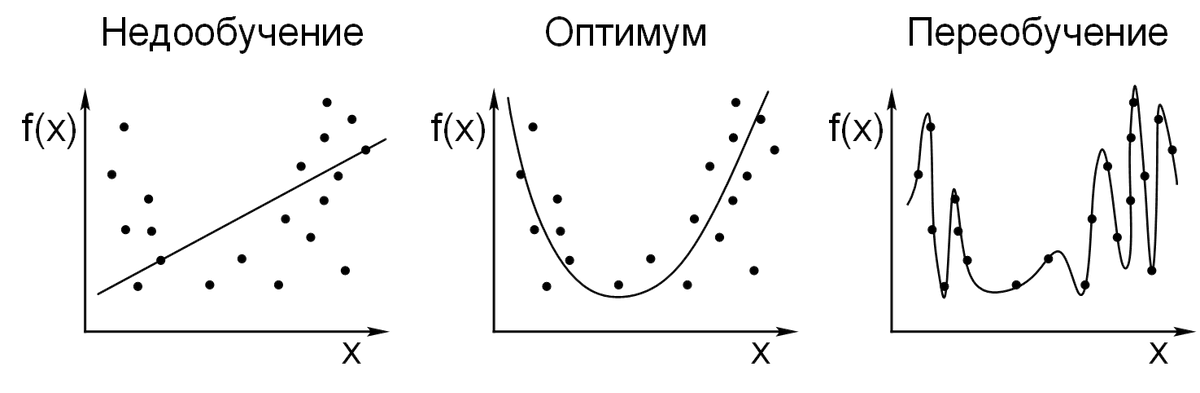

### 5. Попытки улучшить качество

Выше мы могли получить только линейную зависимость от исходных признаков, поэтому может быть полезно добавить преобразования признаков, чтобы в результате модель могла бы предсказывать более сложные зависимости.

Список преобразований, которые могут быть полезны при обучении регрессии:

>1. **Стандартизация данных**. Пусть $x_{ij}$ &mdash; значение признака $j$ для объекта $i$. Обозначим $m_j$ &mdash; выборочное среднее значение признака $j$ (функция `np.mean`), а $s^2_j$ &mdash; выборочную дисперсию признака $j$ (функция `np.var`). Тогда стандартизацией является преобразование
$$\widetilde{x}_{ij} = \frac{x_{ij} - m_j}{s_j}.$$
>
>2. Добавление нелинейности с помощью **полиномиальных признаков**
Создание новых признаков как полиномиальных комбинаций исходных. Полиномиальная регрессия может улучшить модель, если данные обладают нелинейными взаимозависимостями.
>
>3. Логарифмирование
>4. Обработка выбросов
>
Попробуем для текущей задачи подобрать нелинейное преобразование, которое поможет улучшить качество предсказания.




Посмотрим еще раз на истинные и предсказанные медицинские расходы в зависимости от признака `smoker`.

In [44]:
def plot_scatter(
    ax: plt.Axes,
    x: pd.Series,
    y: pd.Series,
    hue: pd.Series,
    title: str,
    xlabel: str,
    ylabel: str,
    alpha: float = 0.6,
    s: int = 150,
) -> None:
    """Строит точечный график с заданными параметрами.

    Параметры:
    ax (plt.Axes): Ось для отображения графика.
    x (pd.Series): Данные по оси X.
    y (pd.Series): Данные по оси Y.
    hue (pd.Series): Данные для различения по цвету (например, категория).
    title (str): Заголовок графика.
    xlabel (str): Подпись оси X.
    ylabel (str): Подпись оси Y.
    alpha (float): Прозрачность точек (по умолчанию 0.6).
    s (int): Размер точек (по умолчанию 150).
    """
    sns.scatterplot(ax=ax, x=x, y=y, hue=hue, alpha=alpha, s=s)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

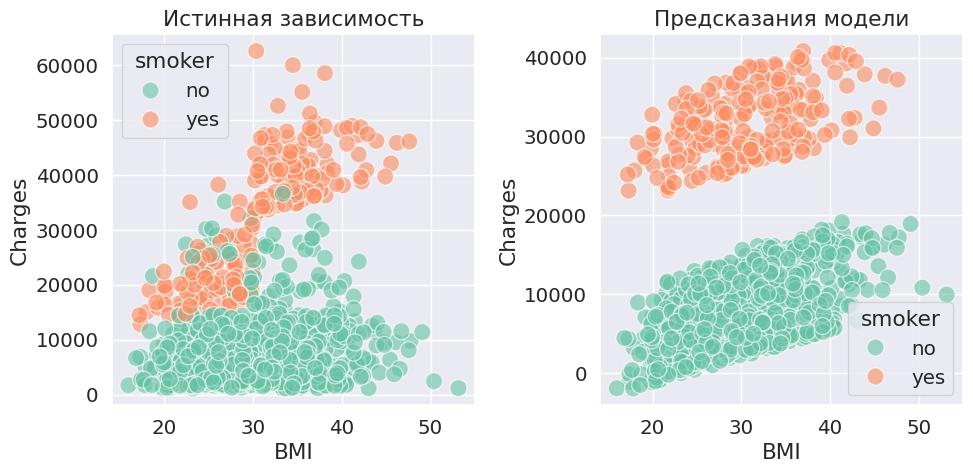

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

plot_scatter(
    axes[0],
    train["bmi"],
    train["charges"],
    train["smoker"],
    "Истинная зависимость",
    "BMI",
    "Charges",
)
plot_scatter(
    axes[1],
    train["bmi"],
    model_dict["все признаки"]["model"].predict(X_train),
    train["smoker"],
    "Предсказания модели",
    "BMI",
    "Charges",
)

plt.tight_layout()
plt.show()

Мы видим, что предсказания `charges` (расходы) увеличиваются на один и тот же коэффициент при росте `bmi` (индекса массы тела) на 1 как для `smoker = "yes"` (курящие), так и для `smoker = "no"` (некурящие).

В то же время по графику реальных данных, то можно заметить, что зависимость расходов от `bmi` отличается в зависимости от признака `smoker`. Есть предположение, что после добавления признака `[smoker * bmi]` предсказания для объектов со значением `smoker = "yes"` улучшатся.


In [46]:
# для обучающей выборки
train["smoker_bmi"] = (train["smoker"] == "yes") * train["bmi"]

# для тестовой выборки
test["smoker_bmi"] = (test["smoker"] == "yes") * test["bmi"]

real_features.extend(["smoker_bmi"])

Обучим модель с новыми признаками

In [47]:
X_train = np.hstack([train[real_features], train_cat])
X_test = np.hstack([test[real_features], test_cat])

model_with_new_feature = LinearRegression()
model_with_new_feature.fit(X_train, train[target_feature])
test_preds_with_new_feature = model_with_new_feature.predict(X_test)

new_model = {
    "model": model_with_new_feature,
    "train_preds": model_with_new_feature.predict(X_train),
    "test_preds": model_with_new_feature.predict(X_test),
}

model_dict["с новым признаком"] = new_model

Посмотрим на предсказания модели с новым признаком.

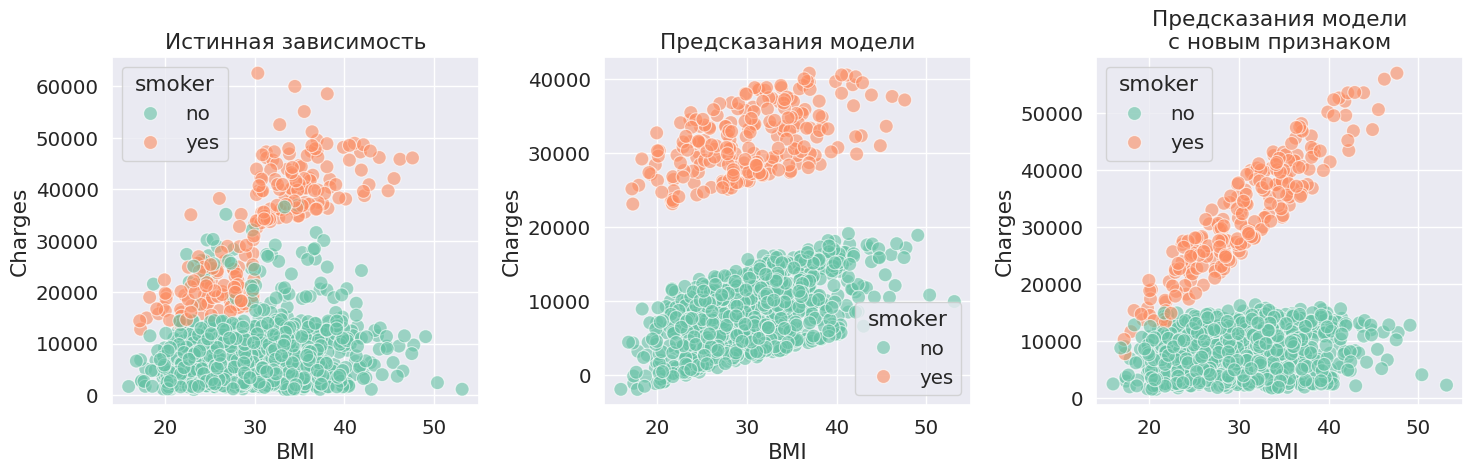

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

plot_scatter(
    axes[0],
    train["bmi"],
    train["charges"],
    train["smoker"],
    "Истинная зависимость",
    "BMI",
    "Charges",
    s=100,
)
plot_scatter(
    axes[1],
    train["bmi"],
    model_dict["все признаки"]["model"].predict(np.hstack([train[real_features[:-1]], train_cat])),
    train["smoker"],
    "Предсказания модели",
    "BMI",
    "Charges",
    s=100,
)
plot_scatter(
    axes[2],
    train["bmi"],
    model_dict["с новым признаком"]["model"].predict(X_train),
    train["smoker"],
    "Предсказания модели\nс новым признаком",
    "BMI",
    "Charges",
    s=100,
)

plt.tight_layout()
plt.show()

Теперь можно увидеть, что при увеличении bmi на 1, charges меняется на значение, которое зависит от признака smoker, т.е. модель учла эту зависимость.

Получим метрики на тестовой выборке

In [49]:
metrics_df = get_regression_metrics_df(test[target_feature], model_dict)
metrics_df

,RMSE,MAE,MAPE,R2
Model,,,,
age,11659.381084,9172.410208,1.265044,0.124365
bmi,12210.039191,9784.652596,1.703504,0.039702
age+bmi,11464.256085,9221.883313,1.303051,0.153428
все признаки,5793.112671,4180.120716,0.468705,0.783830
с новым признаком,4572.470758,2750.922752,0.290165,0.865329


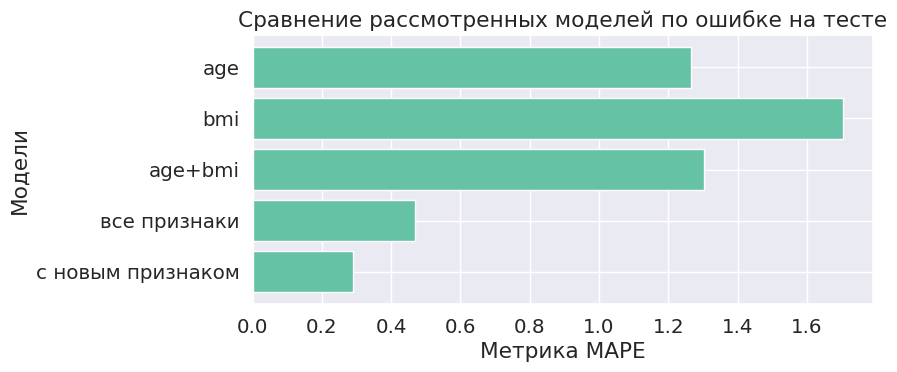

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3.5))
plt.barh(metrics_df.index[::-1], metrics_df["MAPE"][::-1])
plt.title("Сравнение рассмотренных моделей по ошибке на тесте")
plt.xlabel("Метрика MAPE")
plt.ylabel("Модели")
plt.xlim((0, None))
plt.show()


Значение ошибок значительно уменьшилось, с добавлением нового признака получилось повысить качество предсказаний!

Порой линейных моделей недостаточно для точных предсказаний, поэтому появляется необходимость в использовании более сложных моделей и нелинейных зависимостей.

### 6. Интерпретация результатов

> Существует область машинного обучения Explainable AI (XAI), которая занимается тем, что пытается разными способами понять, как работает модель, на какие признаки обращает внимание, насколько является устойчивой... То есть пытается интерпретировать работу модели. Это очень актуальная задача, поскольку таким образом мы можем:
> - узнавать новую информацию о наших данных;
> - понимать, умеет ли модель обращать внимание на действительно важные признаки;
> - находить слабости модели;
> - валидировать ее работу и т. д.
> 
> Сам подход имеет широкое распространение в сфере бизнеса, поскольку модели, используемые для принятия важных 
решений, таких как постановка медицинского диагноза, решение о выдаче кредита, беспилотное управление транспортом и т.п., должны соответствовать ГОСТ 59276-2020, регулирующему доверие к ИИ и объяснимость их результатов. Однако не меньший интерес область вызывает и в науке, например, чтобы понимать важность разных генов для формирования фенотипа и формулировать новые гипотезы.

---
В линейной регрессии коэффициенты характеризуют величину и направление влияния каждого признака на целевую переменную. Однако интерпретация коэффициентов может быть затруднена, если признаки имеют разные единицы измерения или разный диапазон значений, так коэффициенты могут быть соответственно несоизмеримы по величине. Например, изменения в высоте в миллиметрах окажут меньшее влияние на предсказания, чем изменения в метрах, если использовать те же коэффициенты.
Для стандартизации будем использовать [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

>`fit(X)`\
>Метод fit используется для вычисления основных статистик, таких как среднее значение и стандартное отклонение, для каждого признака на предоставленных данных `X`. Эти статистики затем используются для стандартизации признаков.
>
>`transform(X)`:\
>После вычисления статистик с помощью `fit`, метод `transform` применяется для преобразования данных `X`. Он вычитает среднее и делит на стандартное отклонение для каждого признака.
>`fit_transform(X)`:
>Назначение: Этот метод сочетает в себе `fit` и `transform` в одной операции.




Важно помнить, что необходимо выполнять `fit` или `fit_transform` только на тренировочных данных, так как возможна утечка информации из тестового набора данных в тренировочный. Если вы выполните fit на всех данных сразу, то модель может получить дополнительную информацию о тестовых данных, что может помешать объективной оценке качества.


---
Обучим модель после стандартизации данных

In [51]:
# Инициализация и применение StandardScaler
scaler = StandardScaler()
# Внимание! Нельзя вызывать fit_transform на тестовых данных!
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение модели линейной регрессии
model_scaled = LinearRegression()
model_scaled.fit(X_train_scaled, train[target_feature])

LinearRegression()

Посмотрим на значения ошибок и коэффициенты в последней линейной модели и сделаем выводы.

In [52]:
# Коэффициенты модели
coefficients = model_scaled.coef_

# Признаки
encoded_features = encoder.get_feature_names_out()
feature_names = real_features + list(encoded_features)

coef_df = pd.DataFrame({"Признак": feature_names, "Значение коэффициента": coefficients})
coef_df

,Признак,Значение коэффициента
0,age,3707.567529
1,bmi,118.517407
2,children,561.827116
3,smoker_bmi,18612.936237
4,sex_male,-266.120775
5,smoker_yes,-8572.434745
6,region_northwest,-269.509658
7,region_southeast,-427.542403
8,region_southwest,-535.544448


Визуализируем полученные полученные коэффициенты

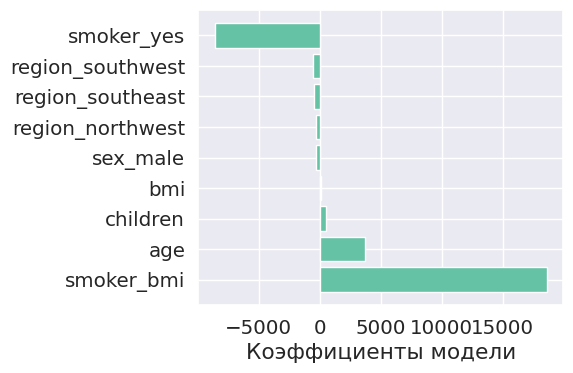

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(6, 4), tight_layout=True)

df_sorted = coef_df.sort_values(by="Значение коэффициента", ascending=False)

ax.barh(df_sorted["Признак"], df_sorted["Значение коэффициента"])
ax.set_xlabel("Коэффициенты модели")
plt.show()

&#x2753; **Вопрос** &#x2753;

> Какие выводы можно сделать на основе полученных коэффициентов?

<details>
  <summary> Кликни для показа ответа </summary>
  
> **Коэффициенты регрессии**
> 
> 1. Возраст (`age`): Коэффициент 3707.57 предполагает, что с увеличением возраста на 1 год, при прочих равных, ожидается увеличение предполагаемых затрат на 3707.57. Это указывает на то, что возраст является существенным фактором.
> 
> 2. Произведение курильщика и индекса массы тела (`smoker_bmi`): Высокий коэффициент 18612.94 указывает на сильный положительный эффект. Это может означать, что взаимодействие между курением и `bmi` оказывает значительное влияние на целевую переменную.




</details><br/>





---

Несмотря на улучшение метрик предсказательной способности, важно понимать, что подобные интерпретации всегда нуждаются в подтверждении на большем количестве данных и более детальной проверке каждой гипотезы. В данном случае добавление нового признака привело к увеличению качества предсказаний, поэтому при подборе новых признаков бывает полезно учитывать природу данных, но в случае, когда зависимости более сложные, имеет смысл рассматривать другие модели.

